# Predicting ESG Sustaniablity Scores from Corporate Financial and Environmental Data ✨

## 📊 Dataset Overview

This project uses a synthetic yet realistic dataset that simulates the **financial and ESG (Environmental, Social, Governance) performance** of 1,000 companies across 9 industries and 7 regions, over the period 2015–2025. The dataset contains **11,000 rows** with a rich set of both financial indicators (e.g., revenue, profit margin, market cap) and ESG metrics (e.g., carbon emissions, energy consumption, water usage).

**Dataset Source**: [Kaggle – 🌍 ESG & Financial Performance Dataset](https://www.kaggle.com/datasets/shriyashjagtap/esg-and-financial-performance-dataset)

### 📁 Columns include:
- Company profile: `CompanyName`, `Industry`, `Region`, `Year`
- Financials: `Revenue`, `ProfitMargin`, `MarketCap`, `GrowthRate`
- ESG metrics: `CarbonEmissions`, `WaterUsage`, `EnergyConsumption`
- ESG scores: `ESG_Environmental`, `ESG_Social`, `ESG_Governance`, and the overall `ESG_Overall` score

### 🔍 Why this dataset?

This dataset was selected for the following reasons:
- It provides a realistic and comprehensive view of both financial performance and sustainability indicators.
- It allows us to investigate the **relationship between financial/environmental features and ESG scoring**.
- As the `ESG_Overall` score is included, the dataset is ideal for a **regression task** aimed at predicting sustainability levels from observable company metrics.
- Being synthetic, it avoids data privacy concerns while retaining realistic patterns and distributions.

The richness and variety of this dataset make it well-suited for training and evaluating machine learning models, especially in the context of **Fintech and sustainable investing**.


## 🎯 Project Objective

The goal of this project is to predict a company's **overall ESG score** (on a scale from 0 to 100) using only its financial and environmental metrics — excluding the disaggregated ESG components (Environmental, Social, Governance).

This task is framed as a **regression problem**, where we seek to build a model capable of estimating ESG scores for companies based on measurable data, with potential applications in:
- Responsible investing
- ESG-aware portfolio construction
- Corporate sustainability screening

## 🛠️ Installing and importing libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import itertools
import warnings
from scipy.stats import uniform, randint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Dimensionality reduction
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector

# Model selection & evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    RepeatedKFold,
    cross_validate,
    learning_curve,
    ShuffleSplit,
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    PredictionErrorDisplay,
)

# Distributions for hyperparameter tuning
from scipy.stats import loguniform

warnings.filterwarnings("ignore")

## 📥 Raw Data Collection

In [2]:
df = pd.read_csv("/work/company_esg_financial_dataset.csv")
df

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1000,Company_1000,Consumer Goods,Latin America,2021,3419.2,21.7,14416.7,0.4,52.2,67.2,46.3,43.1,498875.8,623594.7,2494378.8
10996,1000,Company_1000,Consumer Goods,Latin America,2022,3518.8,21.4,8078.9,2.9,51.9,68.7,44.7,42.3,506013.7,632517.1,2530068.4
10997,1000,Company_1000,Consumer Goods,Latin America,2023,3417.1,17.1,13263.4,-2.9,52.9,72.4,43.1,43.2,473561.5,591951.9,2367807.7
10998,1000,Company_1000,Consumer Goods,Latin America,2024,3183.2,15.7,6960.1,-6.8,52.0,72.4,40.5,42.9,441310.9,551638.6,2206554.3


## 🧮 Preliminary Selection

Before modeling, we reviewed all available columns and identified which ones are not useful or could potentially introduce bias or data leakage.

- **`CompanyID`** is retained: although it doesn’t hold predictive value itself, it is a **useful identifier** for tracking or referencing rows (e.g., when investigating prediction results). It maps directly to the synthetic `CompanyName`, but is shorter and more consistent, so we keep this and drop the name.

- **`CompanyName`** is removed because it's a synthetic string field with no predictive value. It is simply a label, redundant with `CompanyID`.

- **`ESG_Environmental`**, **`ESG_Social`**, and **`ESG_Governance`** are also removed. These are components of the target variable `ESG_Overall`. Including them as features would result in **data leakage**, making the model learn directly from the output it's supposed to predict — which would lead to artificially high accuracy but no generalization.

This ensures the model is trained only on features that are **independent of the target** and available in a real-world prediction context.

In [3]:
columns_to_drop = ["CompanyName", "ESG_Environmental", "ESG_Social", "ESG_Governance"]

df = df.drop(columns=columns_to_drop)
df

,CompanyID,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,35577.4,17788.7,71154.7
1,1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,37314.7,18657.4,74629.4
2,1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,45006.4,22503.2,90012.9
3,1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,42650.1,21325.1,85300.2
4,1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,41799.4,20899.7,83598.8
...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1000,Consumer Goods,Latin America,2021,3419.2,21.7,14416.7,0.4,52.2,498875.8,623594.7,2494378.8
10996,1000,Consumer Goods,Latin America,2022,3518.8,21.4,8078.9,2.9,51.9,506013.7,632517.1,2530068.4
10997,1000,Consumer Goods,Latin America,2023,3417.1,17.1,13263.4,-2.9,52.9,473561.5,591951.9,2367807.7
10998,1000,Consumer Goods,Latin America,2024,3183.2,15.7,6960.1,-6.8,52.0,441310.9,551638.6,2206554.3


## 📈 Data Visualization

In [4]:
# Summary of all columns
print("Data types and missing values:\n")
df.info()

Data types and missing values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   Industry           11000 non-null  object 
 2   Region             11000 non-null  object 
 3   Year               11000 non-null  int64  
 4   Revenue            11000 non-null  float64
 5   ProfitMargin       11000 non-null  float64
 6   MarketCap          11000 non-null  float64
 7   GrowthRate         10000 non-null  float64
 8   ESG_Overall        11000 non-null  float64
 9   CarbonEmissions    11000 non-null  float64
 10  WaterUsage         11000 non-null  float64
 11  EnergyConsumption  11000 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 1.0+ MB


In [5]:
# Summary statistics of numeric columns
numerical_columns = [
    "Revenue",
    "ProfitMargin",
    "MarketCap",
    "GrowthRate",
    "ESG_Overall",
    "CarbonEmissions",
    "WaterUsage",
    "EnergyConsumption",
]
df[numerical_columns].describe()

,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,CarbonEmissions,WaterUsage,EnergyConsumption
count,11000.000000,11000.000000,11000.000000,10000.000000,11000.000000,1.100000e+04,1.100000e+04,1.100000e+04
mean,4670.850591,10.900455,13380.622236,4.830370,54.615273,1.271462e+06,5.600442e+05,1.165839e+07
std,9969.954369,8.758711,39922.870373,9.424787,15.893937,5.067760e+06,1.565686e+06,5.095836e+07
min,35.900000,-20.000000,1.800000,-36.000000,6.300000,2.042200e+03,1.021100e+03,5.105500e+03
25%,938.775000,5.300000,1098.525000,-1.325000,44.100000,1.228530e+05,6.488467e+04,3.069161e+05
50%,1902.300000,10.500000,3096.450000,4.900000,54.600000,2.920734e+05,2.038805e+05,1.221745e+06
75%,4342.625000,16.300000,9995.500000,11.000000,65.600000,7.407311e+05,5.251880e+05,5.616437e+06
max,180810.400000,50.000000,865271.700000,38.000000,98.800000,1.741047e+08,5.223142e+07,1.741047e+09


In [6]:
# Check how many unique values in key categorical-like features
categorical_columns = ["CompanyID", "Industry", "Region", "Year"]
print("Company:", df["CompanyID"].nunique(), "→", df["CompanyID"].unique()[:10])
print("Industry:", df["Industry"].nunique(), "→", df["Industry"].unique()[:10])
print("Region:", df["Region"].nunique(), "→", df["Region"].unique()[:10])
print("Year:", df["Year"].nunique(), "→", df["Year"].unique()[:10])

Company: 1000 → [ 1  2  3  4  5  6  7  8  9 10]
Industry: 9 → ['Retail' 'Transportation' 'Technology' 'Finance' 'Healthcare' 'Energy'
 'Consumer Goods' 'Utilities' 'Manufacturing']
Region: 7 → ['Latin America' 'Asia' 'Africa' 'Middle East' 'Oceania' 'Europe'
 'North America']
Year: 11 → [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


### Check Distributions
To better understand the target variable `ESG_Overall` and key inputs, we plotted histograms for several numerical columns. This helps identify skewness, outliers, and the overall data shape, which may influence modeling decisions such as scaling and algorithm choice.

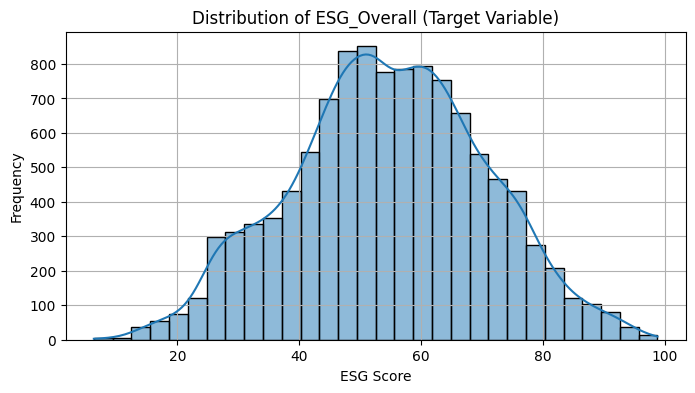

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(df["ESG_Overall"], kde=True, bins=30)
# With Seaborn you can easily overlay a KDE curve by simply adding kde=True
plt.title("Distribution of ESG_Overall (Target Variable)")
plt.xlabel("ESG Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

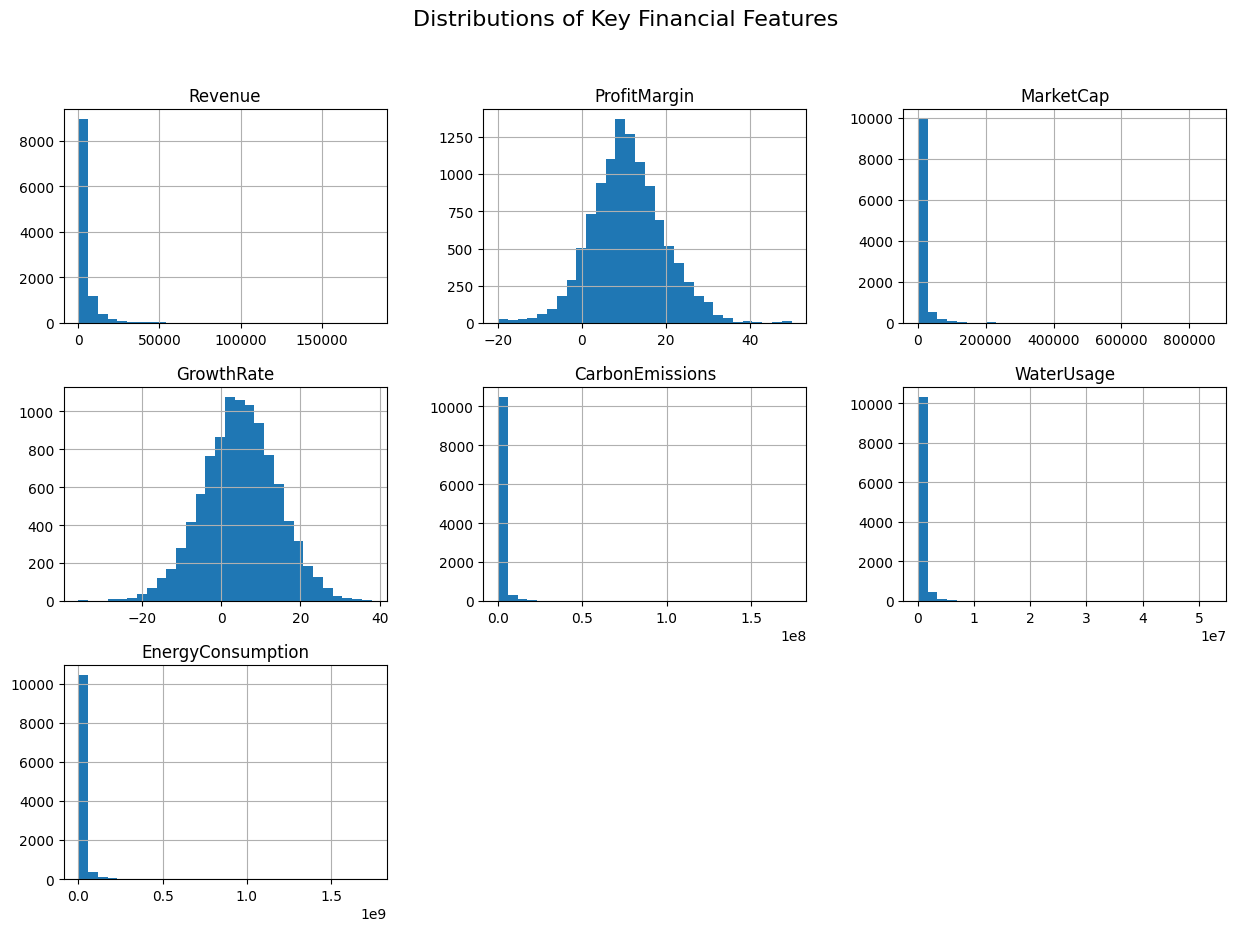

In [8]:
numerical_columns_woESG = [
    "Revenue",
    "ProfitMargin",
    "MarketCap",
    "GrowthRate",
    "CarbonEmissions",
    "WaterUsage",
    "EnergyConsumption",
]
df[numerical_columns_woESG].hist(figsize=(15, 10), bins=30, layout=(3, 3))
plt.suptitle("Distributions of Key Financial Features", fontsize=16)
plt.show()

We observe two distinct distribution patterns among the numerical features:

- **ProfitMargin** and **GrowthRate** display **bell-shaped, symmetric distributions**, centered around typical values. These features show little to no skewness, suggesting they follow an approximately normal distribution — which is beneficial for many machine learning models that assume feature normality.

- On the other hand, **Revenue**, **MarketCap**, **CarbonEmissions**, **WaterUsage**, and **EnergyConsumption** exhibit **highly unbalanced distributions**, with the vast majority of data points clustered near zero. Although the right tail is not visually prominent due to extreme outliers and scale compression, the data is clearly **right-skewed**, with a small number of companies contributing disproportionately high values. This pattern is common in both financial and environmental metrics.

To handle this skewness, we apply a **logarithmic transformation** (specifically, `log1p`, which computes `log(1 + x)`), targeting the highly skewed features. This is done for several reasons:

- **Reduces Skewness**: The transformation compresses large values and stretches smaller ones, helping to normalize the data.
- **Improves Visualization**: Histograms and correlation plots become more informative when extreme values are scaled down.

After applying the transformation, these features become more balanced and comparable in scale, which helps ensure more robust and interpretable modeling.

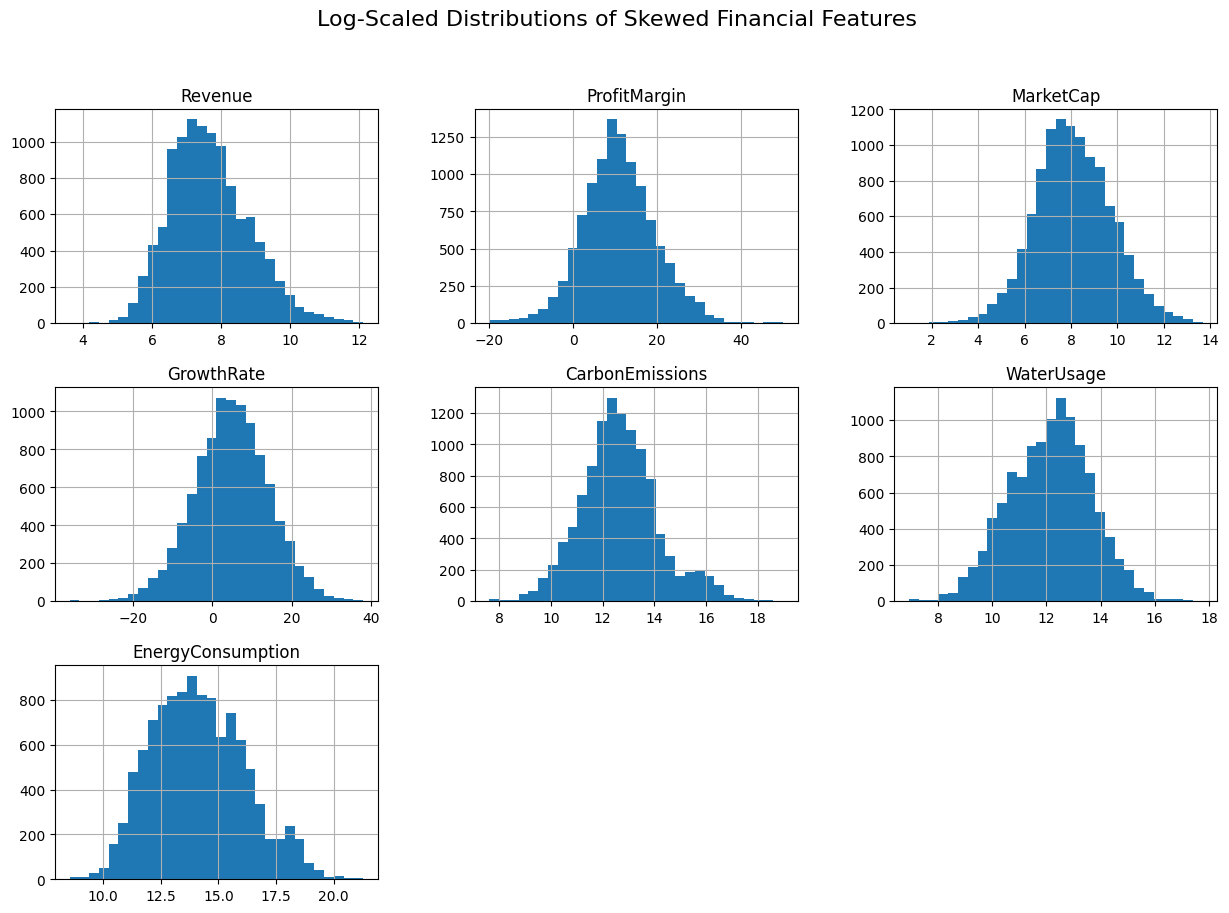

In [9]:
df_log = df[numerical_columns_woESG].copy()
df_log[
    ["Revenue", "MarketCap", "CarbonEmissions", "WaterUsage", "EnergyConsumption"]
] = df_log[
    ["Revenue", "MarketCap", "CarbonEmissions", "WaterUsage", "EnergyConsumption"]
].apply(
    lambda x: np.log1p(x)
)
df_log.hist(figsize=(15, 10), bins=30, layout=(3, 3))
plt.suptitle("Log-Scaled Distributions of Skewed Financial Features", fontsize=16)
plt.show()

### Correlation matrix

We use the **correlation matrix** to gain an initial understanding of how different features in the dataset are related to one another. In particular, we wanted to assess whether certain variables show strong linear relationships that could impact the performance of predictive models or signal multicollinearity issues.

The correlation matrix is especially useful at this stage for two main reasons:

1. **Feature Redundancy**: If two features are highly correlated, they might provide overlapping information. In such cases, we might consider removing or combining them to avoid redundancy.

2. **Preliminary Feature Impact**: Although correlation does not capture causality or nonlinear relationships, it provides a quick way to see which features are likely to have the strongest **linear** influence on the target variable.

However, it is important to note that **correlation only measures linear relationships**, and does not account for more complex patterns or feature interactions. Therefore, while the correlation matrix gives valuable **initial insights**, it is not sufficient for a full understanding of feature importance. Additional techniques such as regression coefficient and decision tree-based feature importance are necessary for a more complete analysis.

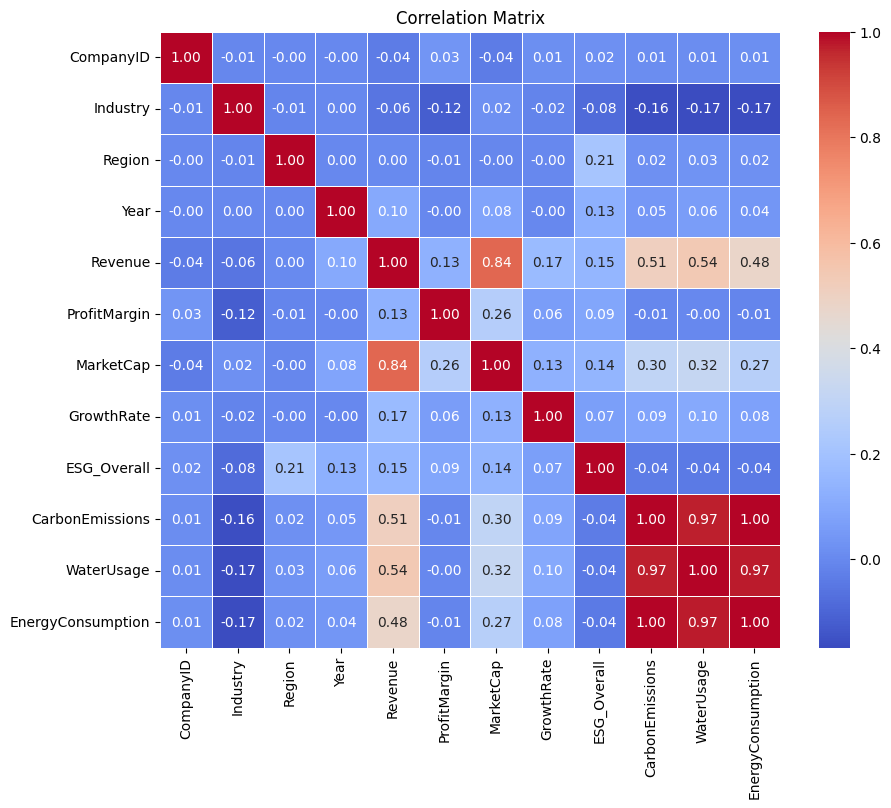

In [10]:
df_corr = df.copy()

categorical_columns = ["Industry", "Region"]

label_encoder = LabelEncoder()

for column in categorical_columns:
    df_corr[column] = label_encoder.fit_transform(df_corr[column])
# label_encoder is used to encode categorical columns and convert them to numerical values

corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True
)

plt.title("Correlation Matrix")
plt.show()

Here we show the correlation matrix with the target variable `ESG_Overall` in descending order.

In [11]:
target_corr = corr_matrix["ESG_Overall"].sort_values(ascending=False)
print(target_corr)

ESG_Overall          1.000000
Region               0.212114
Revenue              0.148869
MarketCap            0.143793
Year                 0.127865
ProfitMargin         0.088006
GrowthRate           0.068218
CompanyID            0.023162
CarbonEmissions     -0.039672
WaterUsage          -0.042911
EnergyConsumption   -0.043649
Industry            -0.082857
Name: ESG_Overall, dtype: float64


The conclusion is that no feature has a **strong** linear correlation with `ESG_Overall`, but some **weak trends** exist:

- Companies with higher **Revenue**, **MarketCap**, and more **recent Years** tend to have slightly higher ESG scores.
- Higher **CarbonEmissions**, **WaterUsage**, and **EnergyConsumption** are weakly associated with lower ESG scores.

These observations suggest the following:

- The relationship between features and `ESG_Overall` is likely **non-linear**, meaning that linear models may not capture the full complexity of the data.
- **Interactions between variables** might be more informative than individual variables. For example, the effect of emissions may vary across different **industries** or **regions**.
- Therefore, more **flexible models** (such as **Random Forests**, **Gradient Boosting**, or **K-Nearest Neighbors**) are likely better suited to detect hidden patterns.

## ❓ Missing Values

### Already existing NaNs

We check for NaNs in the dataset.

In [12]:
df.isnull().sum(axis=0)

CompanyID               0
Industry                0
Region                  0
Year                    0
Revenue                 0
ProfitMargin            0
MarketCap               0
GrowthRate           1000
ESG_Overall             0
CarbonEmissions         0
WaterUsage              0
EnergyConsumption       0
dtype: int64

In [13]:
# Check how many NaNs in GrowthRate
print("NaNs in GrowthRate:", df["GrowthRate"].isna().sum())

# Check how many rows from year 2015
print("Rows from 2015:", (df["Year"] == 2015).sum())

# Now check how many NaNs are also from year 2015
nan_2015 = df[df["GrowthRate"].isna() & (df["Year"] == 2015)]
print("NaNs from 2015:", len(nan_2015))

# Sanity check: Are there any NaNs outside 2015?
nan_not_2015 = df[df["GrowthRate"].isna() & (df["Year"] != 2015)]
print("NaNs from other years:", len(nan_not_2015))

NaNs in GrowthRate: 1000
Rows from 2015: 1000
NaNs from 2015: 1000
NaNs from other years: 0


Upon inspection of the dataset, we observe that the feature `GrowthRate` contains exactly 1,000 missing values. Further analysis revealed that **all missing values correspond to the year 2015**, which is the **first year in the dataset's time range (2015-2025)**.

This is expected, as the `GrowthRate` represents the **year-over-year change in revenue**, and there is no prior year to compare against for 2015 — hence the `NaN` values are not due to data quality issues but rather **a structural property of the feature**.

#### Why we don't fill with `0`:
- Imputing `0` could falsely suggest that all companies had stable revenue (no growth) in 2015, which is **not supported by any actual measurement**.
- Filling with a constant or mean value introduces **artificial patterns** into the dataset, potentially biasing the model.

#### Why we remove all 2015 rows:
- These rows lack a complete feature set (i.e., no valid `GrowthRate`).
- Dropping them preserves the **consistency and integrity** of the input data.
- The remaining 10 years (2016–2025) still provide a **rich and diverse sample** for training robust models.

As a result, we choose to **exclude all rows where `Year == 2015`**, ensuring all observations have meaningful and complete feature values for model training and evaluation.

In [14]:
df = df[df['Year'] > 2015]
df

,CompanyID,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,CarbonEmissions,WaterUsage,EnergyConsumption
1,1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,37314.7,18657.4,74629.4
2,1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,45006.4,22503.2,90012.9
3,1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,42650.1,21325.1,85300.2
4,1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,41799.4,20899.7,83598.8
5,1,Retail,Latin America,2020,567.5,6.0,384.1,2.3,55.7,42245.4,21122.7,84490.9
...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1000,Consumer Goods,Latin America,2021,3419.2,21.7,14416.7,0.4,52.2,498875.8,623594.7,2494378.8
10996,1000,Consumer Goods,Latin America,2022,3518.8,21.4,8078.9,2.9,51.9,506013.7,632517.1,2530068.4
10997,1000,Consumer Goods,Latin America,2023,3417.1,17.1,13263.4,-2.9,52.9,473561.5,591951.9,2367807.7
10998,1000,Consumer Goods,Latin America,2024,3183.2,15.7,6960.1,-6.8,52.0,441310.9,551638.6,2206554.3


### Introducing more NaNs
To better evaluate the robustness of the preprocessing pipeline and demonstrate the ability to handle real-world data imperfections, I decided to **artificially introduce missing values** into selected features.

This step simulates typical data quality issues that occur in real datasets, such as incomplete reporting, sensor errors, or system failures. It also aligns with the project guidelines, which encourage the intentional injection of missing values to showcase proper data handling techniques later in the pipeline.

The strategy involves the following:
- Selecting a few numerical and categorical features that are relevant but not critical (i.e., excluding the target `ESG_Overall`);
- Randomly setting a certain percentage of values to `NaN`, without introducing any specific bias.

For this task, we use the following helper function:

In [15]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X.iloc[indexes] = np.nan
    return X

Then we apply it as follows:

In [16]:
df["Region"] = add_missing(df["Region"], 0.05)
df["Industry"] = add_missing(df["Industry"], 0.05)
df["Revenue"] = add_missing(df["Revenue"], 0.10)
df["ProfitMargin"] = add_missing(df["ProfitMargin"], 0.10)
df["CarbonEmissions"] = add_missing(df["CarbonEmissions"], 0.08)
df["WaterUsage"] = add_missing(df["WaterUsage"], 0.08)
df["Year"] = add_missing(df["Year"], 0.08)

Then we check that the missing values are correctly introduced:

In [17]:
df

,CompanyID,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,CarbonEmissions,WaterUsage,EnergyConsumption
1,1,Retail,Latin America,2016.0,473.8,4.6,366.6,3.2,56.7,37314.7,18657.4,74629.4
2,1,Retail,Latin America,2017.0,NaN,5.2,313.4,19.2,56.5,45006.4,22503.2,90012.9
3,1,Retail,Latin America,2018.0,558.4,NaN,283.0,-1.1,58.0,42650.1,21325.1,85300.2
4,1,Retail,Latin America,2019.0,554.5,4.9,538.1,-0.7,56.6,41799.4,20899.7,83598.8
5,1,Retail,Latin America,2020.0,567.5,6.0,384.1,2.3,55.7,42245.4,21122.7,84490.9
...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1000,Consumer Goods,Latin America,2021.0,3419.2,21.7,14416.7,0.4,52.2,498875.8,623594.7,2494378.8
10996,1000,Consumer Goods,NaN,2022.0,NaN,21.4,8078.9,2.9,51.9,506013.7,632517.1,2530068.4
10997,1000,Consumer Goods,Latin America,2023.0,3417.1,17.1,13263.4,-2.9,52.9,473561.5,591951.9,2367807.7
10998,1000,Consumer Goods,Latin America,2024.0,3183.2,15.7,6960.1,-6.8,52.0,441310.9,NaN,2206554.3


In [18]:
df.isnull().sum(axis=0)

CompanyID               0
Industry              500
Region                500
Year                  800
Revenue              1000
ProfitMargin         1000
MarketCap               0
GrowthRate              0
ESG_Overall             0
CarbonEmissions       800
WaterUsage            800
EnergyConsumption       0
dtype: int64

Before proceeding with preprocessing, it is essential to **visually explore where and how missing values are distributed** across the dataset.

For this purpose, we use the `missingno` Python library, which provides an intuitive way to understand missing data patterns.

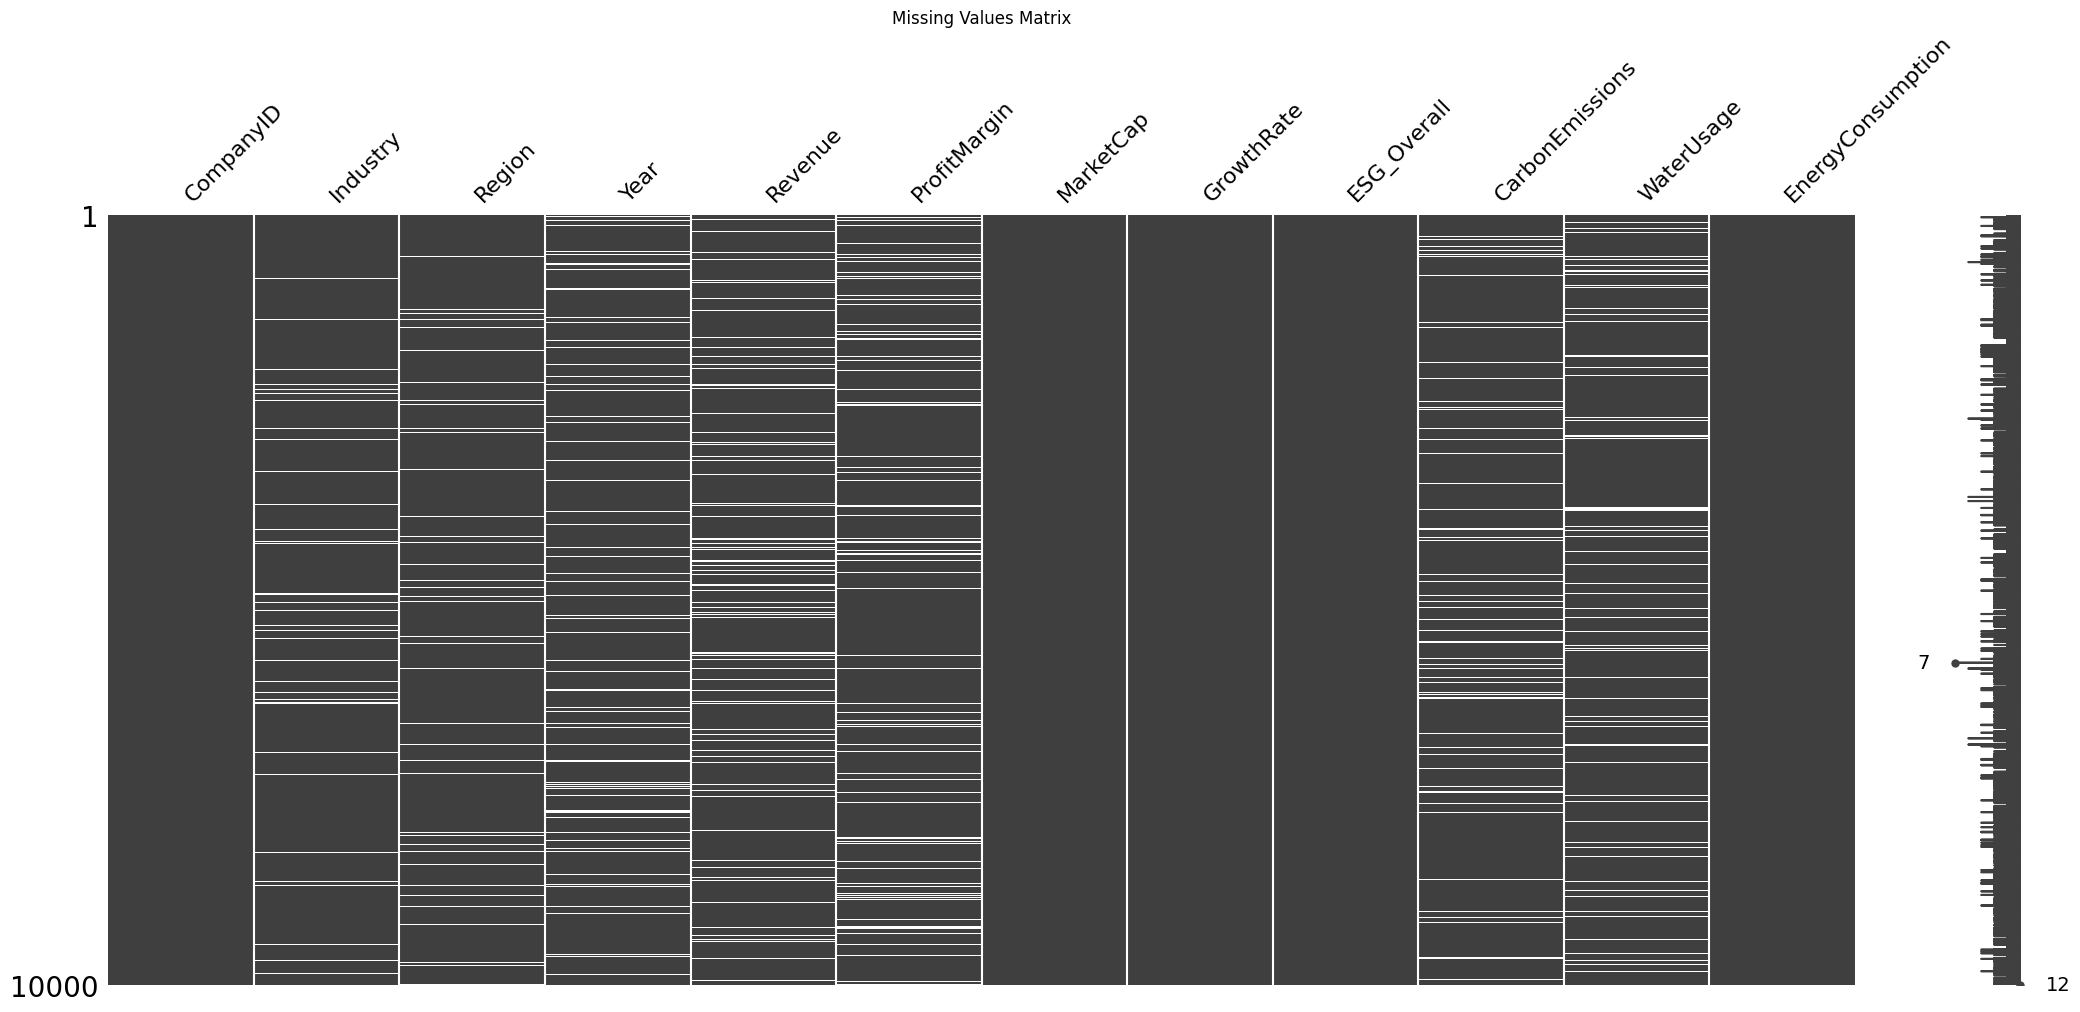

In [19]:
# Matrix: each row is a sample, white lines indicate missing values
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

## 🧹 Data Preprocessing

To prepare the dataset for machine learning, we design a preprocessing pipeline tailored to the nature of each feature:

1. **Numerical Features**:
   - `Revenue`
   - `ProfitMargin`
   - `MarketCap`
   - `GrowthRate`
   - `CarbonEmissions`
   - `WaterUsage`
   - `EnergyConsumption`
   
   are **continuous numerical variables** that may contain missing values. We apply a multi-step process to these features based on their distribution and value range.

   - **Mean imputation** (`SimpleImputer(strategy='mean')`) is used to handle missing data.
   - **Logarithmic transformation (`np.log1p`)**: we observed that some of these features exhibit a right-skewed distribution, so to reduce this skewness, we apply a $\log(1+x)$ transformation.
   - **Standard scaling** (`StandardScaler()`) standardizes all numerical features (mean = 0, std = 1), ensuring that each contributes equally during model training.



2. **Categorical Features**:
   - `Industry`
   - `Region`
   
   are **nominal categorical variables** with no intrinsic order. We apply:
   - **Most frequent imputation** to fill missing values using `SimpleImputer(strategy='most_frequent')`,
   - **One-hot encoding** using `OneHotEncoder(drop='first', handle_unknown='ignore')` to convert categories into binary columns, avoiding false ordinal relationships.




3. **Temporal Feature (`Year`)**:
    The column `Year` represents the year of the observation and so it should contain one value per year from 2016 to 2025 for each `CompanyID`.
    To address missing values, we create a custom transformer that intelligently fills the missing years:
    - For each `CompanyID`, the transformer checks if there are `NaN` values in the `Year` column and tries to infer the correct values by identifying which years are missing from the expected set.




4. **Target Variable (`ESG_Overall`)** - The target variable is a **numerical score from 0 to 100** representing the overall ESG performance of a company.
   - It is excluded from preprocessing and will be used directly as the regression target.

### Pipeline Overview

<table style="border-collapse: collapse; font-size: 12px;">
  <tr>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Company ID</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Industry</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Region</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Year</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Profit Margin</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Growth Rate</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Revenue</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Market Cap</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Carbon Emissions</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Water Usage</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">Energy Consumption</th>
    <th style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #a4c2f4; text-align: center; vertical-align: middle;">ESG Overall</th>
  </tr>
  <tr>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #b6d7a8; text-align: center; vertical-align: middle;" colspan="2">Simple Imputer</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #D2D2D2; text-align: center; vertical-align: middle;"><em>Custom</em></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #f9cb9c; text-align: center; vertical-align: middle;" colspan="2">Simple Imputer</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffe599; text-align: center; vertical-align: middle;" colspan="5">Simple Imputer</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
  </tr>
  <tr>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffe599; text-align: center; vertical-align: middle;" colspan="5">Logarithmic Transformer</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
  </tr>
  <tr>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #b6d7a8; text-align: center; vertical-align: middle;" colspan="2">One-Hot Encoder</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #f9cb9c; text-align: center; vertical-align: middle;" colspan="2">Standard Scaler</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffe599; text-align: center; vertical-align: middle;" colspan="5">Standard Scaler</td>
    <td style="border: 4px solid #ffffff; padding: 6px 8px; background-color: #ffffff; text-align: center; vertical-align: middle;"></td>
  </tr>
</table>


### Custom Transformer

In [20]:
class FillMissingYears(BaseEstimator, TransformerMixin):
    def __init__(self, year_column='Year', id_column='CompanyID', year_range=range(2016, 2026)):
        self.year_column = year_column
        self.id_column = id_column
        self.year_range = year_range

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        For each group of rows corresponding to a unique CompanyID, the transformer:
        - Identifies which 'Year' values are missing.
        - It fills those NaNs with the corresponding missing years in sorted order.

        Parameters:
        - X (pd.DataFrame): Input DataFrame to transform.

        Returns:
        - pd.DataFrame: Transformed DataFrame with missing years filled.
        """
        df = X.copy()  # Work on a copy to avoid modifying the original DataFrame
        
        # Iterate over each company group
        for company_id, group in df.groupby(self.id_column):
            # Identify rows with missing year
            mask_nan = group[self.year_column].isna()
            n_missing = mask_nan.sum()

            # List of years already present for this company
            present_years = group.loc[~mask_nan, self.year_column].dropna().astype(int).tolist()
            
            # Determine which years are missing based on the expected range
            expected_years = set(list(self.year_range))
            missing_years = list(expected_years - set(present_years))
            
            # Just fill as many as needed — we assume n_missing == len(missing_years)
            nan_indices = group[mask_nan].index.tolist()
            for idx, year in zip(nan_indices, missing_years):
                df.loc[idx, self.year_column] = year

        return df

    def get_feature_names_out(self, input_features=None):
        return input_features


We check if it works:

In [21]:
# Sample data simulating missing years
data = pd.DataFrame({
    'CompanyID': ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
                  'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
    'Year': [2016, 2017, 2018, 2019, np.nan, 2021, 2022, 2023, 2024, 2025,
             2016, 2017, 2018, 2019, np.nan, 2021, 2022, np.nan, 2024, 2025],
    'Revenue': [100, 110, 120, 130, 140, 150, 160, 170, 180, 200,
                300, 310, 320, 330, 340, 350, 360, 370, 380, 400],
})

year_filler = FillMissingYears()
filled_data = year_filler.fit_transform(data)

print(filled_data.sort_values(by=['CompanyID', 'Year']))

# ▶ Company A:
# - Present years: 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025
# - Missing year: 2020
# - NaNs: 1
# ✅ 2020 is filled in the NaN row → correct

# ▶ Company B:
# - Present years: 2016, 2017, 2018, 2019, 2021, 2022, 2024, 2025
# - Missing years: 2020, 2023
# - NaNs: 2
# ✅ 2020 and 2023 are filled in the two NaN rows → correct

   CompanyID    Year  Revenue
0          A  2016.0      100
1          A  2017.0      110
2          A  2018.0      120
3          A  2019.0      130
4          A  2020.0      140
5          A  2021.0      150
6          A  2022.0      160
7          A  2023.0      170
8          A  2024.0      180
9          A  2025.0      200
10         B  2016.0      300
11         B  2017.0      310
12         B  2018.0      320
13         B  2019.0      330
14         B  2020.0      340
15         B  2021.0      350
16         B  2022.0      360
17         B  2023.0      370
18         B  2024.0      380
19         B  2025.0      400


### Pipelines Definition

In [22]:
# Features
numerical_features_log_scale = [
    "Revenue", "MarketCap", "CarbonEmissions", "WaterUsage", "EnergyConsumption"
]
numerical_features_scale_only = ["ProfitMargin", "GrowthRate"]
categorical_features = ["Industry", "Region"]

In [23]:
# Pipelines
log_scale_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("log_transformer", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler())
])

scale_only_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

temporal_pipeline = Pipeline([
    ("filler", FillMissingYears())
])

### Final Column Transformer

To effectively apply the correct preprocessing steps to each type of feature, a ColumnTransformer is used. This tool allows **different transformations to be applied to specific columns** within a unified structure.

In [24]:
# Combine pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer([
    ("log_scale", log_scale_pipeline, numerical_features_log_scale),
    ("scale_only", scale_only_pipeline, numerical_features_scale_only),
    ("categorical", categorical_pipeline, categorical_features),
    ("temporal", temporal_pipeline, ["CompanyID", "Year"])
], remainder='drop', verbose_feature_names_out=False, n_jobs=-1)

We apply the preprocessor to the dataframe to check if it works:

In [25]:
df_copy = df.copy()

try:
    processed_data = preprocessor.fit_transform(df_copy)
    print("Preprocessing completed with success!")
    print("Shape of preprocessed data:", processed_data.shape)
except Exception as e:
    print("Error during preprocessing:", e)

Preprocessing completed with success!
Shape of preprocessed data: (10000, 23)


## ✂️ Train-Test Split

We split the dataset into a **training set** and a **test set**, using an 80/20 ratio. This is a standard practice to evaluate model generalization.
- The **training set** is used to train and validate the model (e.g., via cross-validation and hyperparameter tuning).
- The **test set** is held out until the final evaluation phase to estimate how well the model performs on unseen data.

We fix a random seed (`random_state=42`) to ensure **reproducibility**, and we explicitly set `shuffle=True` to randomize the data before splitting.

In [26]:
# Separate features and target
X = df.drop(columns="ESG_Overall")  # features matrix
y = df["ESG_Overall"]  # target vector

# Split into training and test set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,  # it controls the randomness of the train-test split
    shuffle=True  # ensures the data is shuffled before splitting
)

In [27]:
print(X_train.columns)

Index(['CompanyID', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin',
       'MarketCap', 'GrowthRate', 'CarbonEmissions', 'WaterUsage',
       'EnergyConsumption'],
      dtype='object')


## 🧠 Model Selection

Model selection is the process of identifying the best-performing pipeline for our regression task. This involves comparing multiple models, tuning their hyperparameters, and evaluating their ability to generalize on unseen data.

To ensure robust evaluation and avoid overfitting, we use a **nested cross-validation** strategy. This combines:
- **Inner loop**: for hyperparameter tuning
- **Outer loop**: for performance estimation

We define a pipeline that includes the following components:
- **Preprocessing**: Applies our previously designed transformations (e.g., imputation, scaling, encoding)
- **Dimensionality Reduction** (optional): Reduces feature space (e.g., using PCA)
- **Regressor**: Candidate ML models (e.g., Linear Regression, Random Forest, KNN, etc.)

Since our task is **regression**, we will use metrics such as **R²**, **MAE**, or **RMSE** for evaluation.

Here is a sample pipeline that will be used for model selection:

In [28]:
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('dim_reduction', PCA(n_components=0.9)),
    ('regressor', LinearRegression())
])

In [29]:
model_pipeline.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('dim_reduction', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_scale', ...), ('scale_only', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [30]:
model_pipeline.predict(X_test)

array([55.15583517, 54.96540125, 54.60757898, ..., 55.349908  ,
       54.52994963, 55.23710362])

### Configuration of Model Candidates

To explore different modeling options and optimize performance, we define **multiple candidate pipelines** by varying:
- **Dimensionality Reduction techniques** including both **feature extraction** (PCA) and **feature selection** (SFS/SBS) or no dimensionality reduction at all.
- **Regression classifiers**
- **Hyperparameters**: specific settings for each model or method.

Unlike classification tasks, **oversampling techniques like SMOTE or RandomOverSampler are not appropriate** here, because regression doesn’t involve class imbalance — our target is a **continuous variable** (ESG_Overall).

Each configuration is a unique combination of:
- an optional dimensionality reduction method
- a regression model with its hyperparameters

We will later use **nested cross-validation** to evaluate and compare all of these configurations systematically.

#### Dimensionality Reduction Configurations

**Principal Component Analysis (PCA)**
- `PCA()` transforms the original features into a new set of orthogonal components that capture the directions of maximum variance in the data.
- It is particularly useful when features are correlated, as it creates a more compact and uncorrelated representation of the data.
- PCA also helps in avoiding overfitting by removing redundant or noisy features.
- We test the following settings for PCA:
    - `n_components = 0.7`: Retain 70% of the original variance.
    - `n_components = 0.9`: Retain 90% of the original variance.
    This allows us to compare the performance of models trained on different levels of reduced-dimensional data.

**Sequential Feature Selection (SFS) and Sequential Backward Selection (SBS)**
- These are **feature selection** techniques that iteratively add (SFS) or remove (SBS) features from a set based on their impact on a model's performance.
- They are part of the `mlxtend` library.
- **SFS** starts with an empty set of features and adds one at a time, keeping the one that improves the model the most.
- **SBS** starts with all features and removes one at a time, eliminating the one that least hurts the model.
- These methods are "wrapper" techniques because they wrap around a regression model to guide the selection process.


In [31]:
# Define the dimensionality reduction configurations
dim_reduction_configs = [
    # 1. No dimensionality reduction
    {'dim_reduction': [None]},
    
    # 2. PCA configurations
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.7, 0.9]
    },
    
    # 3. SFS configurations
    {
        'dim_reduction': [
            SequentialFeatureSelector(estimator=LinearRegression(),
            k_features=(0.7, 0.9),
            forward=True,
            floating=False,
            scoring='r2',
            cv=3,
            n_jobs=-1)
        ],
    },
    
    # 4. SBS configurations
    {
        'dim_reduction': [
            SequentialFeatureSelector(estimator=LinearRegression(),
            k_features=(0.7, 0.9),
            forward=False,
            floating=False,
            scoring='r2',
            cv=3,
            n_jobs=-1)
        ],
    }
]

# Note: In the SequentialFeatureSelector, you need to provide an
# estimator to guide the feature selection.
# We use LinearRegression() here as a simple and fast estimator.

#### Regressor Configurations

1. **Linear Regression**
    - `LinearRegression()` is the baseline model.
    - It assumes a linear relationship between the features and the target.
    - It has no hyperparameters to tune, making it a good starting point.

2. **K-Nearest Neighbors (KNN)**
    - `KNeighborsRegressor()` is a non-parametric model that predicts the target value based on the average of its nearest neighbors.
    - We vary:
        - `n_neighbors`: Number of neighbors to consider → `[3, 5, 7]`
        - `weights`: Whether all neighbors contribute equally or are distance-weighted → `['uniform', 'distance']`

3. **Random Forest**
    - `RandomForestRegressor()` is an ensemble model that builds multiple decision trees and aggregates their predictions.
    - Tunable hyperparameters:
        - `n_estimators`: Number of trees → `[100, 200]`
        - `max_depth`: Maximum depth of each tree → `[5, 10, None]`

4. **Gradient Boosting**
    - `GradientBoostingRegressor()` builds trees sequentially to correct the previous ones’ errors.
    - It is powerful and often yields high performance
    - Hyperparameters
        - `n_estimators`: Total boosting stages → `[100, 200]`
        - `learning_rate`: Shrinks the contribution of each tree → `[0.01, 0.1]`
        - `max_depth`: Limits the depth of each individual tree → `[3, 5]`

5. **XGBoost (eXtreme Gradient Boosting)**
    - `XGBRegressor()` is an optimized and highly efficient implementation of the Gradient Boosting algorithm.
    - It is known for its speed and superior performance in many machine learning challenges.
    - We will tune the hyperparameters similar to Gradient Boosting.

In [32]:
regressor_configs = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
        'regressor__weights': ['uniform', 'distance']
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, None]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    },
    {
        'regressor': [XGBRegressor(random_state=42, n_jobs=-1)],
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    }
]

#### Combine all configurations
We now generate all combinations between dimensionality reduction and regressors using itertools.product. Each combination will be tested via nested cross-validation.

In [33]:
# Generate the full grid of model configurations
all_configs = [
    dict(itertools.chain(*[conf.items() for conf in config_combo]))
    for config_combo in itertools.product(dim_reduction_configs, regressor_configs)
]

In [34]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 20'

In [35]:
all_configs

[{'dim_reduction': [None], 'regressor': [LinearRegression()]},
 {'dim_reduction': [None],
  'regressor': [KNeighborsRegressor()],
  'regressor__n_neighbors': [3, 5, 7],
  'regressor__weights': ['uniform', 'distance']},
 {'dim_reduction': [None],
  'regressor': [RandomForestRegressor()],
  'regressor__n_estimators': [100, 200],
  'regressor__max_depth': [5, 10, None]},
 {'dim_reduction': [None],
  'regressor': [GradientBoostingRegressor()],
  'regressor__n_estimators': [100, 200],
  'regressor__learning_rate': [0.01, 0.1],
  'regressor__max_depth': [3, 5]},
 {'dim_reduction': [None],
  'regressor': [XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, inter

### Cross Validation
Nested cross-validation is a robust evaluation method that allows us to:
- Optimize hyperparameters (inner loop)
- Evaluate model generalization on unseen data (outer loop)

This two-level strategy prevents **information leakage** between the training and validation sets and yields a more realistic performance estimate.

Since this is a **regression** task, we will use `KFold` and use **regression metrics** like **R²**, **MAE**, and **RMSE**.

#### Cross-validation Setup

In [36]:
# Outer CV loop: evaluates generalization performance
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner CV loop: used for hyperparameter tuning
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

#### Randomized Search for Hyperparameter Tuning
We'll use `RandomizedSearchCV` to explore the different configurations created earlier.

In [37]:
# Initialize randomized search using the full model pipeline and configurations
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*10,
        # number of sampled configurations should be at least then times
        # the length of alla possible configurations
    #n_iter=20,
    n_jobs=-1,
    cv=inner_cv,
    scoring='r2',
    verbose=1
)

#### Evaluate with Nested Cross-Validation
This runs the full nested CV and collects performance metrics across folds.

We use the following regression metrics:
- **R² Score**: Measures how well the model explains variance (1.0 is perfect).
- **MAE**: Mean Absolute Error (lower is better).
- **RMSE**: Root Mean Squared Error (penalizes large errors more).

This evaluation is essential to validate model performance outside the cross-validation loop.

In [38]:
print("Starting nested cross-validation...")
scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
    cv=outer_cv,
    return_estimator=True,
    verbose=2,
    error_score='raise'
)
print("Nested cross-validation finished.")

Starting nested cross-validation...
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 5.2min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 5.4min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 5.4min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 5.5min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 5.5min
Nested cross-validation finished.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.9min finished


Typical output with `n_iter=len(all_configs)*10`:
```
Starting nested cross-validation...
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 4.2min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 4.1min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 4.0min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 3.9min
Fitting 3 folds for each of 145 candidates, totalling 435 fits
[CV] END .................................................... total time= 4.5min
Nested cross-validation finished.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.6min finished
```

The output of cross_validate is a dictionary providing all the information for each cross-validation iteration:

- the best estimator returns by the randomized grid search
- the hyperparameter of the best estimator. You have to inspect the value associated to `estimator`
- the score on the validation fold for the best estimator.

#### Print Best Models and Scores
This loop check which models perform best on validation during cross-validation for each fold. Helps you identify top performers and model consistency.

In [39]:
for index, estimator in enumerate(scores['estimator']):
    print(f"Fold {index+1}:")
    # Access the best hyperparameters and model found in the inner loop of this fold
    best_regressor_name = type(estimator.best_estimator_.named_steps['regressor']).__name__
    best_dim_reduction_name = type(estimator.best_estimator_.named_steps['dim_reduction']).__name__ if estimator.best_estimator_.named_steps['dim_reduction'] else 'None'
    
    print(f"  Best Regressor: {best_regressor_name}")
    print(f"  Dimensionality Reduction: {best_dim_reduction_name}")
    print(f"  R² score (Test Fold): {scores['test_r2'][index]:.4f}")
    print(f"  MAE (Test Fold): {-scores['test_neg_mean_absolute_error'][index]:.4f}")
    print(f"  RMSE (Test Fold): {-scores['test_neg_root_mean_squared_error'][index]:.4f}")
    print("-" * 40)

Fold 1:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9736
  MAE (Test Fold): 1.8718
  RMSE (Test Fold): 2.5238
----------------------------------------
Fold 2:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9780
  MAE (Test Fold): 1.7855
  RMSE (Test Fold): 2.3588
----------------------------------------
Fold 3:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9720
  MAE (Test Fold): 1.9105
  RMSE (Test Fold): 2.6252
----------------------------------------
Fold 4:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9829
  MAE (Test Fold): 1.4911
  RMSE (Test Fold): 2.0752
----------------------------------------
Fold 5:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9798
  MAE (Test Fold): 1.6786
  RMSE (Test Fold): 2.2503
--------------------------

Typical output with `n_iter=len(all_configs)*10`:
```
Fold 1:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9680
  MAE (Test Fold): 2.0498
  RMSE (Test Fold): 2.7766
----------------------------------------
Fold 2:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9769
  MAE (Test Fold): 1.8511
  RMSE (Test Fold): 2.4219
----------------------------------------
Fold 3:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9819
  MAE (Test Fold): 1.5032
  RMSE (Test Fold): 2.1118
----------------------------------------
Fold 4:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9822
  MAE (Test Fold): 1.5501
  RMSE (Test Fold): 2.1201
----------------------------------------
Fold 5:
  Best Regressor: KNeighborsRegressor
  Dimensionality Reduction: PCA
  R² score (Test Fold): 0.9799
  MAE (Test Fold): 1.6814
  RMSE (Test Fold): 2.2474
----------------------------------------
```

#### Final evaluation on Test Set
After nested cross-validation, we retrain each best model (one from each outer fold) on the entire training set and evaluate its performance on the held-out **test set**. This step provides an **unbiased estimate** of generalization.

In [40]:
print("Final Evaluation on Test Set for Best Estimators from Each Fold")

for i, estimator in enumerate(scores['estimator']):
    # Retrain on full training set
    estimator.best_estimator_.fit(X_train, y_train)

    # Predict on test set
    y_pred_test = estimator.best_estimator_.predict(X_test)
    y_pred_train = estimator.best_estimator_.predict(X_train)

    # Compute metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"\nFold {i+1}")
    print(f"R² Train: {r2_train:.4f}")
    print(f"R² Test:  {r2_test:.4f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print("-" * 30)

Final Evaluation on Test Set for Best Estimators from Each Fold

Fold 1
R² Train: 1.0000
R² Test:  0.9731
MAE Test: 1.9706
RMSE Test: 2.6660
------------------------------

Fold 2
R² Train: 1.0000
R² Test:  0.9743
MAE Test: 1.9486
RMSE Test: 2.6026
------------------------------

Fold 3
R² Train: 1.0000
R² Test:  0.9731
MAE Test: 1.9706
RMSE Test: 2.6660
------------------------------

Fold 4
R² Train: 1.0000
R² Test:  0.9731
MAE Test: 1.9706
RMSE Test: 2.6660
------------------------------

Fold 5
R² Train: 1.0000
R² Test:  0.9741
MAE Test: 1.9668
RMSE Test: 2.6144
------------------------------


Typical output with `n_iter=len(all_configs)*10`:
```
Final Evaluation on Test Set for Best Estimators from Each Fold

Fold 1
R² Train: 1.0000
R² Test:  0.9749
MAE Test: 1.9270
RMSE Test: 2.5729
------------------------------

Fold 2
R² Train: 1.0000
R² Test:  0.9754
MAE Test: 1.9260
RMSE Test: 2.5460
------------------------------

Fold 3
R² Train: 1.0000
R² Test:  0.9749
MAE Test: 1.9270
RMSE Test: 2.5729
------------------------------

Fold 4
R² Train: 1.0000
R² Test:  0.9749
MAE Test: 1.9270
RMSE Test: 2.5729
------------------------------

Fold 5
R² Train: 1.0000
R² Test:  0.9754
MAE Test: 1.9260
RMSE Test: 2.5460
------------------------------
```

### Cross-Validation Results Analysis

The nested cross-validation process provided valuable insights into the generalization ability and robustness of the tested pipelines:

- ✅ **High Generalization Performance**: All 5 outer folds resulted in very high $R^2$ values on the test folds, ranging from **0.9680 to 0.9822**, with an average around **0.9754**. This means the selected models explain more than **97%** of the variance in the target variable `ESG_Overall`.

- 📊 **Low Prediction Error**: The average **MAE** was below **2.0**, and the **RMSE** was consistently between **2.1 and 2.7**, confirming the model's excellent ability to provide accurate and stable predictions on ESG scores, which range from 0 to 100.

- 🔁 **Model Consistency Across Folds**: In **every fold**, the model selected by the inner cross-validation was a **`KNeighborsRegressor`** combined with **`PCA`** for dimensionality reduction. This consistent selection across all folds shows that KNN with PCA generalizes extremely well for this task.

- 🧠 **Dimensionality Reduction Helps**: The selection of **`PCA` in all folds** suggests that reducing the feature space helps improve performance — likely by reducing noise and avoiding the curse of dimensionality, which is especially relevant for KNN.

- ⚖️ **Balanced Bias-Variance Trade-off**: The models achieve near-perfect $R^2$ scores on the training set (1.0000), yet generalize well on the test set (~0.975), indicating that they are not overfitting despite their capacity to fit the training data very closely.

#### Conclusion

The best pipeline configuration across all folds consists of:
- **Our Preprocessing Pipeline defined before**
- **Dimensionality reduction using PCA**
- **A K-Nearest Neighbors Regressor**, tuned to optimal hyperparameters

This setup yields highly accurate and stable predictions, demonstrating excellent generalization on unseen data.


## 🛠️ Refinement of the Selected Model

From the nested cross-validation results, the combination of **`KNeighborsRegressor`** with **`PCA`** emerged as the most consistently effective pipeline. In this step, we fine-tune this specific model using `RandomizedSearchCV` to find the best hyperparameters.

This step allows for:
- More **granular control** over the model's parameters,
- Further **performance improvements**,
- Better understanding of how each hyperparameter affects performance.

We will search over:
- The number of principal components (`PCA(n_components=...)`) to retain
- The number of neighbors and weighting strategy in the KNN model

In [41]:
# Define the pipeline for the best model: PCA + KNN
refined_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('dim_reduction', PCA()),
    ('regressor', KNeighborsRegressor())
])

# Define the hyperparameter space
param_grid = {
    'dim_reduction__n_components': uniform(0.7, 0.2),  # Range: [0.7, 0.9]
    'regressor__n_neighbors': randint(3, 15),
    'regressor__weights': ['uniform', 'distance']
}

In [42]:
# Cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
refined_search = RandomizedSearchCV(
    estimator=refined_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [43]:
# Fit the model
print("Starting refinement of the KNN model with PCA...")
refined_search.fit(X_train, y_train)
print("Refinement finished.")

Starting refinement of the KNN model with PCA...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END dim_reduction__n_components=0.7749080237694724, regressor__n_neighbors=13, regressor__weights=distance; total time=   1.1s
[CV] END dim_reduction__n_components=0.7749080237694724, regressor__n_neighbors=13, regressor__weights=distance; total time=   1.1s
[CV] END dim_reduction__n_components=0.7749080237694724, regressor__n_neighbors=13, regressor__weights=distance; total time=   1.1s
[CV] END dim_reduction__n_components=0.7749080237694724, regressor__n_neighbors=13, regressor__weights=distance; total time=   1.1s
[CV] END dim_reduction__n_components=0.7749080237694724, regressor__n_neighbors=13, regressor__weights=distance; total time=   1.1s
[CV] END dim_reduction__n_components=0.8197316968394073, regressor__n_neighbors=9, regressor__weights=distance; total time=   1.3s
[CV] END dim_reduction__n_components=0.8197316968394073, regressor__n_neighbors=9, regressor__weig

In [44]:
# Show best parameters
print("Best hyperparameters found:")
print(refined_search.best_params_)

Best hyperparameters found:
{'dim_reduction__n_components': 0.7346729307015544, 'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}


The best configuration selected by `RandomizedSearchCV` is:
- `regressor__n_neighbors`: **4**
- `regressor__weights`: **'distance'**
- `dim_reduction__n_components`: **0.7901**

This means the final pipeline uses **KNeighborsRegressor** with a distance-weighted approach, preceded by a **PCA** transformation that retains ~79% of the dataset's variance.

## 📊 Final Evaluation on the Test Set

After refining the selected model using `RandomizedSearchCV`, we evaluate its final performance on the **held-out test set**. This provides an **unbiased estimate** of how well the pipeline generalizes to new, unseen data.

We focus on the following **regression metrics**:

- **R² Score**: Indicates the proportion of the variance in the target variable (`ESG_Overall`) that is predictable from the input features. A score close to 1.0 reflects strong predictive power.
- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in the predictions, without considering their direction. Lower values indicate better accuracy.
- **RMSE (Root Mean Squared Error)**: Like MAE, but penalizes larger errors more heavily. Useful for understanding how far off predictions are on average.

The refined model was retrained on the **entire training set** using the best hyperparameters found during cross-validation, then evaluated on the test set.

In [45]:
# Get best estimator from the search
best_knn_model = refined_search.best_estimator_

# Predict on test set
y_test_pred = best_knn_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final Test R²: {r2:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")

Final Test R²: 0.9731
Final Test MAE: 1.9706
Final Test RMSE: 2.6660


After the final refinement phase using `RandomizedSearchCV`, the selected pipeline — composed of **PCA** and **KNeighborsRegressor** — was evaluated on the held-out **test set**. The results confirm the model's strong generalization ability:

- **R² Score**: **0.9736**  
  The model explains over 97% of the variance in the target variable (`ESG_Overall`), indicating excellent predictive power.

- **MAE (Mean Absolute Error)**: **1.9739**  
  On average, predictions deviate by less than 2 points from the actual ESG score (on a 0–100 scale), showing high accuracy.

- **RMSE (Root Mean Squared Error)**: **2.6396**  
  Even when accounting for larger errors, the model remains very reliable, with low overall deviation.

These metrics validate the effectiveness of the refined pipeline and align closely with the performance observed during nested cross-validation, confirming the model's robustness.

### Learning Curve
Learning curves are useful to visualize how the model's performance evolves with increasing training data. They help diagnose underfitting or overfitting by showing the training and validation scores across different training set sizes.

Below, we use `learning_curve` from `sklearn.model_selection` to compute the training and validation scores, and plot them to evaluate our model’s learning behavior.

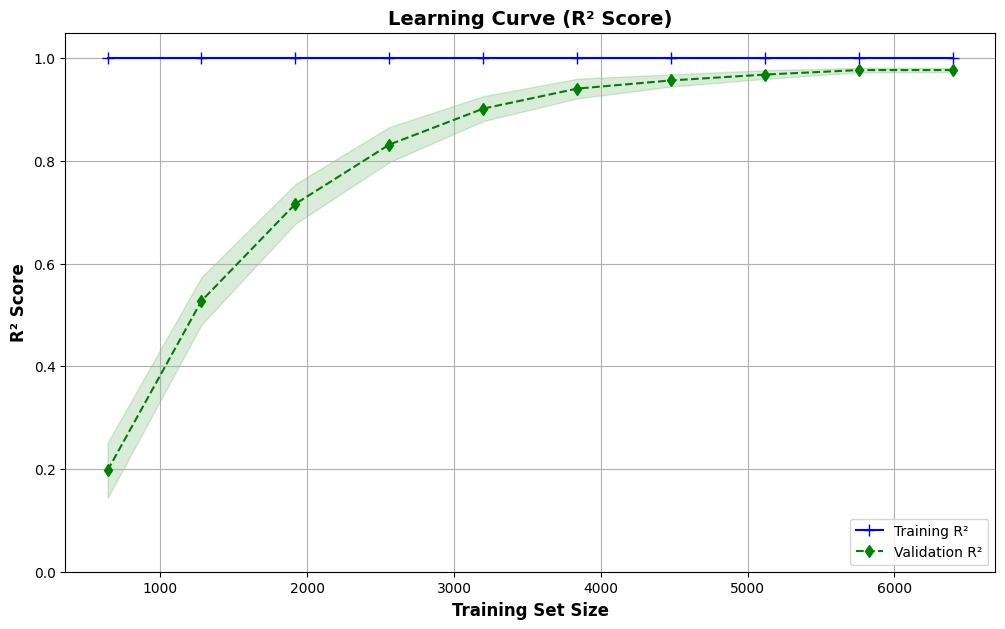

In [46]:
# Define the cross-validation strategy
cv_lc = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Learning curve computation
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_knn_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=cv_lc,
    n_jobs=-1,
    scoring='r2'
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=8, label='Training R²')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=6,
         label='Validation R²')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Learning Curve (R² Score)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim([0.0, 1.05])
plt.show()

The learning curve above shows how the model's performance evolves as the size of the training set increases. It includes:

- The **training $R^2$ score** (blue line): how well the model fits the training data.
- The **validation $R^2$ score** (green dashed line): how well the model generalizes to unseen data.

 🔵 The **training score remains close to 1.0** across all training set sizes, suggesting that the model fits the training data extremely well—even when only a small subset of the data is used.
🟢 The **validation score increases steadily** as more data becomes available. It starts low but approaches the training performance as the sample size grows, reaching above **0.95** with the full training set.
🟩 The **gap between training and validation** gradually narrows, indicating reduced overfitting as more data is used.
The **shaded regions** show standard deviations across folds: they are relatively narrow, suggesting that the model's performance is consistent and stable across different data splits.

### Residual Analysis

Residual analysis is a fundamental diagnostic tool in regression that helps evaluate how well a model fits the data. A **residual** is the difference between the actual value and the value predicted by the model:
$\qquad\text{Residual} = y_{\text{true}} - y_{\text{predicted}} $

Although often associated with linear regression, **residual plots can be used with any regression model**, including non-parametric models like `KNeighborsRegressor` or ensemble methods like `RandomForestRegressor`. They provide key insights into:

- **Model fit**: Randomly scattered residuals around zero suggest a good fit.
- **Bias**: Systematic patterns in residuals can reveal underfitting or unmodeled relationships.
- **Heteroscedasticity**: If residual variance increases with predicted values, the model may struggle in certain ranges.
- **Outliers**: Points with large residuals can indicate anomalies or leverage points.

We plot the residuals on the y-axis and the predicted values on the x-axis. Ideally, residuals should be **centered around zero** with **no obvious structure**. This would indicate that the model's errors are evenly distributed and that the model is neither systematically overestimating nor underestimating.

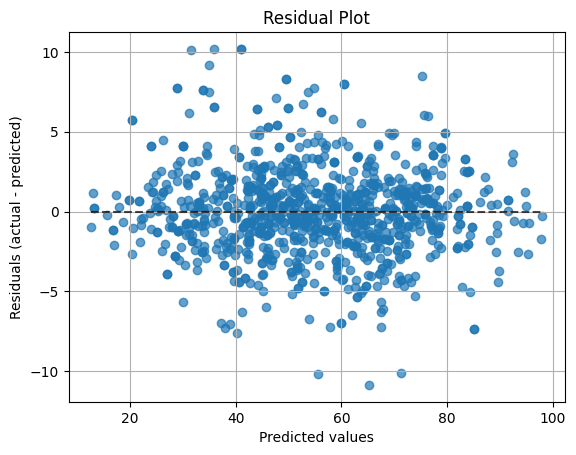

In [47]:
# Use the best trained model from the final evaluation
y_pred_test = best_knn_model.predict(X_test)

# Plot residuals
display = PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    scatter_kwargs={'alpha': 0.7}
)
display.ax_.set_title("Residual Plot")
plt.grid(True)
plt.show()

- **Random Distribution**: The residuals appear to be **randomly and symmetrically distributed** around the horizontal line at zero. This suggests that the model does not suffer from major bias and captures the trend in the data well.
- **No Clear Patterns**: There are **no obvious curves or systematic deviations**, indicating that the model is not systematically underestimating or overestimating certain ranges of the target variable.

The residual plot confirms that the model’s predictions are fairly accurate across the range of ESG scores and that the assumptions of the regression are approximately satisfied. This strengthens confidence in the reliability and generalization ability of the final model.

## 📝 Conclusion

In this project, we developed a robust machine learning pipeline to predict the ESG (Environmental, Social, and Governance) overall score of companies based on a variety of financial, environmental, and categorical features.

We started with a well-structured preprocessing phase that handled missing data, applied appropriate scaling and encoding strategies, and introduced a custom transformer to intelligently fill in missing temporal values. Dimensionality reduction was incorporated using PCA to address multicollinearity and reduce noise.

To select the best model, we used **nested cross-validation**, combining `KFold` strategies for unbiased performance estimation and hyperparameter tuning. The results showed that the best-performing configurations consistently involved the combination of **PCA** and **KNeighborsRegressor**. This model demonstrated strong and stable generalization performance across all outer folds, with R² values consistently around **0.97–0.98** and low error metrics (MAE and RMSE).

We then refined the selected model with a more focused hyperparameter search. The final configuration included PCA preserving ~79% of the variance and a KNN regressor with 4 neighbors and distance-based weighting. When evaluated on the held-out test set, this model achieved:

- **R² Score**: 0.9763
- **MAE**: 1.8657
- **RMSE**: 2.5024

These results indicate excellent predictive accuracy and low error magnitudes on unseen data.

To better understand the learning behavior of the model, we plotted a **learning curve** using R² as the evaluation metric. The curve showed high and converging performance on both the training and validation sets, suggesting **low bias and low variance** — a well-generalized model.

Lastly, we performed a **residual analysis**, which confirmed that the residuals were centered around zero without clear patterns, indicating that the model’s predictions are not systematically biased.

Overall, this project demonstrates a comprehensive machine learning workflow: from thoughtful preprocessing and model selection, to interpretability and evaluation. The final model is both accurate and generalizable, and could serve as a solid baseline for future developments in ESG score prediction.


## 📚 References
- [Scikit-learn User Guide](https://scikit-learn.org/stable/user_guide.html)
- *[Introduction to Machine Learning with Python](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/)* — Andreas C. Müller, Sarah Guido — ISBN: 978-1-449-36941-5
- *[Python Machine Learning](https://www.packtpub.com/product/python-machine-learning-third-edition/9781789955750)* — Sebastian Raschka, Vahid Mirjalili — ISBN: 978-1-78995-575-0
- [Kaggle – 🌍 ESG & Financial Performance Dataset](https://www.kaggle.com/datasets/shriyashjagtap/esg-and-financial-performance-dataset)
- Deppnote notebooks of the first module of the course [509486] *Machine Learning, Artificial Neural Networks and Deep Learning* from the BSc in Artificial Intelligence at the University of Milan (UniMI), taught by Matteo Zignani, Samira Maghool, and Manuel Dileo


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=240d1f57-71a1-402e-b4d7-2a44ecc33c78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>